In [1]:
import numpy as np
import pandas as pd 
import wave


In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.3.0+cu121
2.3.0+cu121
cuda


In [3]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

# SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [ ]:
torchaudio.utils.sox_utils.list_read_formats()

In [4]:
str(torchaudio.list_audio_backends())

"['sox']"

In [7]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [8]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [20]:
SPEECH_FILE = "../novice/audio/audio_0.wav"
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform, sample_rate 

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000)

In [10]:
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

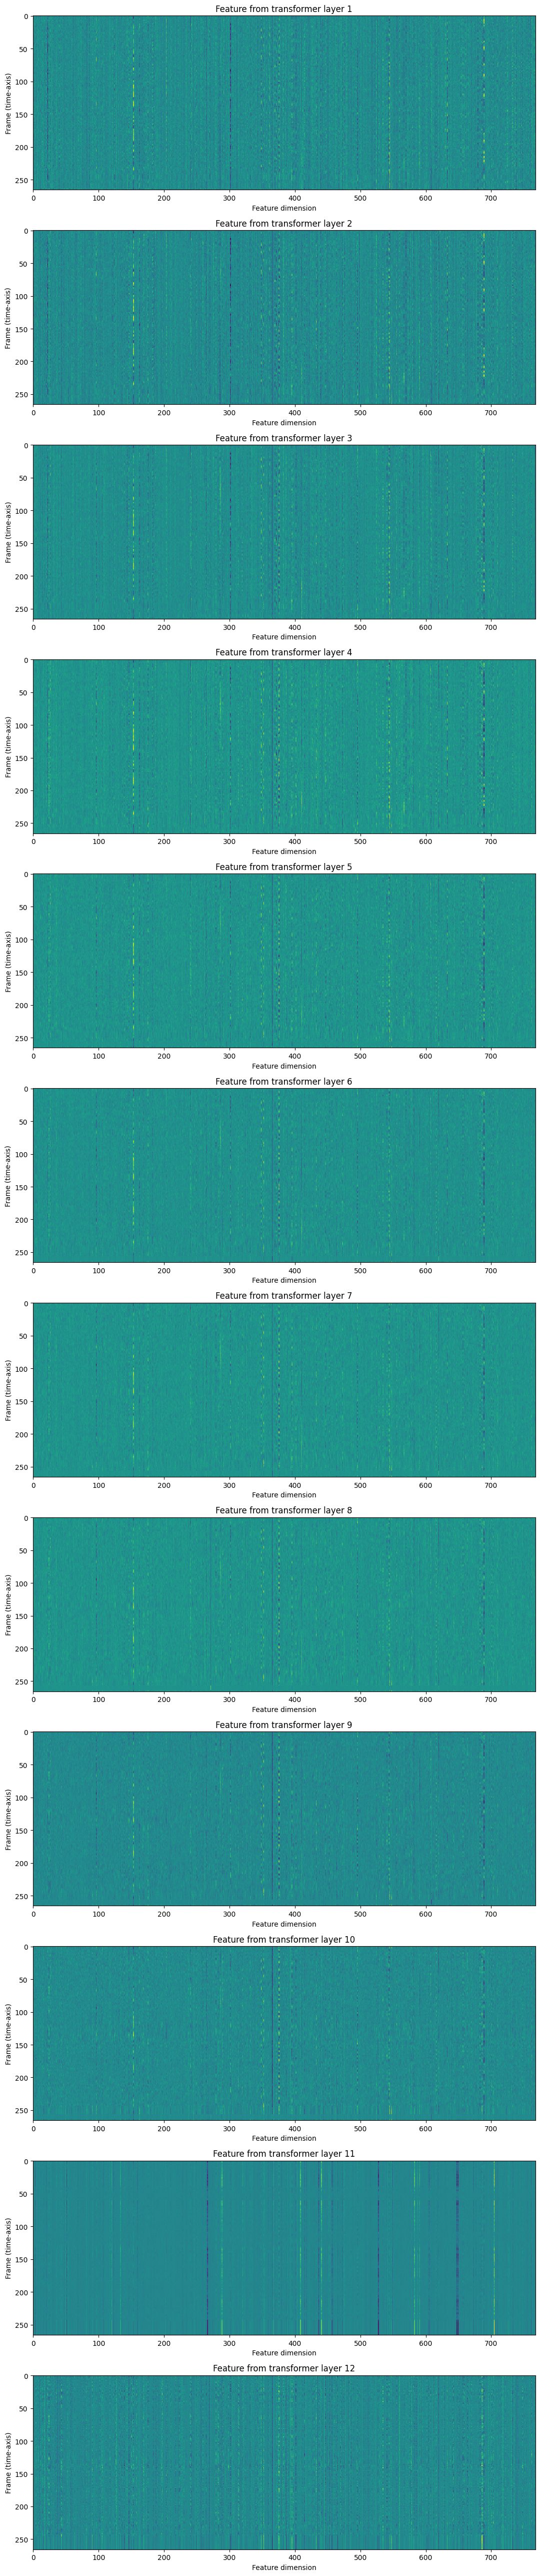

In [12]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
    fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
    for i, feats in enumerate(features):
        ax[i].imshow(feats[0].cpu(), interpolation="nearest")
        ax[i].set_title(f"Feature from transformer layer {i+1}")
        ax[i].set_xlabel("Feature dimension")
        ax[i].set_ylabel("Frame (time-axis)")
    fig.tight_layout()

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


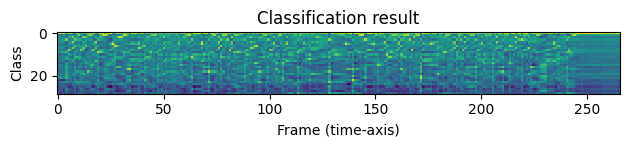

In [13]:
with torch.inference_mode():
    emission, _ = model(waveform)
    plt.imshow(emission[0].cpu().T, interpolation="nearest")
    plt.title("Classification result")
    plt.xlabel("Frame (time-axis)")
    plt.ylabel("Class")
    plt.tight_layout()
    print("Class labels:", bundle.get_labels())

In [17]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] if self.labels[i] != "|" else " " for i in indices])

In [22]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])
transcript

# Supposed to get "Heading is one five zero, target is green commercial aircraft, tool to deploy is electromagnetic pulse."

'THAT HEN AS ONE FINDS FELO DOG IN THE STRING TO MOSOLETROV TOWARD OF THE BOYS AN E COMAGNETIC ONTS '

In [23]:
IPython.display.Audio(SPEECH_FILE)